# Modelo CC

In [1]:
# Modelo TPH
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
#import d3rlpy
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import re
from dateutil.parser import parse
import string
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_percentage_error
import missingno as msno
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import scipy
import researchpy as rp
from matplotlib.offsetbox import AnchoredText
#import pacmap
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import plotly.express as px
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split 
# Import Halving Grid Search
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
import xgboost as xgb
from scipy.stats import kurtosis,skew
from numpy import mean,sqrt,square
from scipy.fftpack import fft, fftfreq
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

In [3]:
df_events = pd.read_csv("../../data/processed data/events_08September2023.csv")
df_events.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [4]:
df_events_train=df_events[(df_events["Flag"]=="E") | (df_events["Flag"]=="S")]
df_events_train.head(1)

,inicio perdida,fin perdida,inicio evento,fin evento,impacto TPH,variación HH TPH,std HH TPH,Causalidad sistema de control,Causalidad molino vacio,Tipo de evento,Flag,duración evento
0,2018-01-01 00:51:00,2018-01-01 01:30:00,2018-01-01 00:41:00,2018-01-01 01:40:00,6.131858,False,0.0,False,False,Embancamiento,E,39.0


In [5]:
tags=['granulometry', 'charge cell', 'speed', 'solid percentage', 'water','TPH', 'HH TPH', 'LL charge cell', 'HH charge cell',

#"loss of TPH","start loss of TPH"	,"end loss of TPH",		"start low load cell",	"end low load cell",		"start high load cell",	"end high load cell","high load cell","low load cell",
#"Optimizando tonelaje","Limitado por Peso",
"delta HH TPH","delta HH charge cell",
#'pyrite law', 'chalcopyrite law','chalcocite law', 'crusher index', 'ball work index','bornite law','covelin law',
'sag power index',

"Edad"
]

In [6]:
df_full=pd.read_csv("../../data/processed data/feature_engineering_event_to_train_09September2023.csv",parse_dates=['Timestamp'], index_col='Timestamp').drop(["Unnamed: 0"],axis=1)
df_full["start high load cell"]=df_full["start high load cell"].shift(-5)
df_full.dropna(inplace=True)
df_full.head()

,granulometry,charge cell,speed,solid percentage,water,TPH,HH TPH,LL charge cell,HH charge cell,loss of TPH,start loss of TPH,end loss of TPH,start low load cell,end low load cell,start high load cell,end high load cell,delta HH TPH,delta HH charge cell,high load cell,low load cell,pyrite law,chalcopyrite law,chalcocite law,crusher index,sag power index,ball work index,bornite law,covelin law,Edad,mean_granulometry_10,max_granulometry_10,min_granulometry_10,rms_granulometry_10,var_granulometry_10,mean_granulometry_5,max_granulometry_5,min_granulometry_5,rms_granulometry_5,var_granulometry_5,mean_granulometry_3,max_granulometry_3,min_granulometry_3,rms_granulometry_3,var_granulometry_3,mean_charge cell_10,max_charge cell_10,min_charge cell_10,rms_charge cell_10,var_charge cell_10,mean_charge cell_5,max_charge cell_5,min_charge cell_5,rms_charge cell_5,var_charge cell_5,mean_charge cell_3,max_charge cell_3,min_charge cell_3,rms_charge cell_3,var_charge cell_3,mean_speed_10,max_speed_10,min_speed_10,rms_speed_10,var_speed_10,mean_speed_5,max_speed_5,min_speed_5,rms_speed_5,var_speed_5,mean_speed_3,max_speed_3,min_speed_3,rms_speed_3,var_speed_3,mean_solid percentage_10,max_solid percentage_10,min_solid percentage_10,rms_solid percentage_10,var_solid percentage_10,mean_solid percentage_5,max_solid percentage_5,min_solid percentage_5,rms_solid percentage_5,var_solid percentage_5,mean_solid percentage_3,max_solid percentage_3,min_solid percentage_3,rms_solid percentage_3,var_solid percentage_3,mean_water_10,max_water_10,min_water_10,rms_water_10,var_water_10,mean_water_5,max_water_5,min_water_5,rms_water_5,var_water_5,mean_water_3,max_water_3,min_water_3,rms_water_3,var_water_3,mean_TPH_10,max_TPH_10,min_TPH_10,rms_TPH_10,var_TPH_10,mean_TPH_5,max_TPH_5,min_TPH_5,rms_TPH_5,var_TPH_5,mean_TPH_3,max_TPH_3,min_TPH_3,rms_TPH_3,var_TPH_3,mean_HH TPH_10,max_HH TPH_10,min_HH TPH_10,rms_HH TPH_10,var_HH TPH_10,mean_HH TPH_5,max_HH TPH_5,min_HH TPH_5,rms_HH TPH_5,var_HH TPH_5,mean_HH TPH_3,max_HH TPH_3,min_HH TPH_3,rms_HH TPH_3,var_HH TPH_3,mean_LL charge cell_10,max_LL charge cell_10,min_LL charge cell_10,rms_LL charge cell_10,var_LL charge cell_10,mean_LL charge cell_5,max_LL charge cell_5,min_LL charge cell_5,rms_LL charge cell_5,var_LL charge cell_5,mean_LL charge cell_3,max_LL charge cell_3,min_LL charge cell_3,rms_LL charge cell_3,var_LL charge cell_3,mean_HH charge cell_10,max_HH charge cell_10,min_HH charge cell_10,rms_HH charge cell_10,var_HH charge cell_10,mean_HH charge cell_5,max_HH charge cell_5,min_HH charge cell_5,rms_HH charge cell_5,var_HH charge cell_5,mean_HH charge cell_3,max_HH charge cell_3,min_HH charge cell_3,rms_HH charge cell_3,var_HH charge cell_3,mean_delta HH TPH_10,max_delta HH TPH_10,min_delta HH TPH_10,rms_delta HH TPH_10,var_delta HH TPH_10,mean_delta HH TPH_5,max_delta HH TPH_5,min_delta HH TPH_5,rms_delta HH TPH_5,var_delta HH TPH_5,mean_delta HH TPH_3,max_delta HH TPH_3,min_delta HH TPH_3,rms_delta HH TPH_3,var_delta HH TPH_3,mean_delta HH charge cell_10,max_delta HH charge cell_10,min_delta HH charge cell_10,rms_delta HH charge cell_10,var_delta HH charge cell_10,mean_delta HH charge cell_5,max_delta HH charge cell_5,min_delta HH charge cell_5,rms_delta HH charge cell_5,var_delta HH charge cell_5,mean_delta HH charge cell_3,max_delta HH charge cell_3,min_delta HH charge cell_3,rms_delta HH charge cell_3,var_delta HH charge cell_3,mean_sag power index_10,max_sag power index_10,min_sag power index_10,rms_sag power index_10,var_sag power index_10,mean_sag power index_5,max_sag power index_5,min_sag power index_5,rms_sag power index_5,var_sag power index_5,mean_sag power index_3,max_sag power index_3,min_sag power index_3,rms_sag power index_3,var_sag power index_3,mean_Edad_10,max_Edad_10,min_Edad_10,rms_Edad_10,var_Edad_10,mean_Edad_5,max_Edad_5,min_Edad_5,rms_Edad_5,var_Edad_5,mean_Edad_3,max_Edad_3,min_Edad_3,rms_Edad_3,var_Edad_3,granulometry_(t-1),granulometry_(t-2),granulometry_(t-3),granulometry_(t-4)

In [7]:
df_full["Edad"]=df_full["Edad"].astype("category")

In [8]:
df_full["start high load cell"].value_counts()

0.0    361747
1.0      3729
Name: start high load cell, dtype: int64

In [9]:
others=[ 'start loss of TPH',
 'end loss of TPH',
 'start low load cell',
 'end low load cell',
 'end high load cell','high load cell',
 'low load cell','pyrite law', 'chalcopyrite law','chalcocite law', 
 'crusher index', 'ball work index','bornite law','covelin law',"Flag"]

In [82]:
features1=["Edad","random","delta HH charge cell","HH TPH"]+[i for i in df_full.columns if (not re.match(".*water",i)) and (not re.match(".*delta",i)) and (not re.match(".*Edad",i)) and (not re.match(".*TPH",i))]
features = list(set(features1).difference(set(others)))

In [83]:
df_full['random'] = np.random.rand(df_full.shape[0])

In [13]:
#df_full=df_full[features]

In [84]:
# Entrenamiento
entrenamiento=pd.concat([df_full["2020-01":"2020-03"],df_full["2020-05"],df_full["2020-07":"2020-12"],df_full["2021-01":"2021-08"],df_full["2021-10"],df_full["2021-12"]])[features]
entrenamiento.head(1)

,sag power index_(t-3),mean_HH charge cell_3,max_LL charge cell_3,max_solid percentage_3,mean_HH charge cell_5,max_sag power index_3,sag power index_(t-2),solid percentage_(t-3),var_granulometry_3,rms_LL charge cell_3,min_HH charge cell_10,mean_granulometry_10,max_LL charge cell_5,speed_(t-4),max_granulometry_5,min_HH charge cell_5,mean_sag power index_10,rms_solid percentage_3,min_granulometry_10,granulometry_(t-5),min_speed_5,var_LL charge cell_3,min_solid percentage_3,speed_(t-2),LL charge cell,speed_(t-5),var_LL charge cell_5,mean_granulometry_5,HH charge cell_(t-4),var_sag power index_5,mean_granulometry_3,max_HH charge cell_3,LL charge cell_(t-5),rms_charge cell_10,max_solid percentage_10,mean_charge cell_5,var_granulometry_5,speed_(t-1),solid percentage,max_HH charge cell_5,HH charge cell_(t-3),min_solid percentage_10,var_solid percentage_10,rms_sag power index_5,HH charge cell_(t-2),rms_HH charge cell_10,speed_(t-3),mean_solid percentage_10,rms_solid percentage_10,delta HH charge cell,mean_solid percentage_5,rms_HH charge cell_3,Edad,rms_charge cell_5,max_speed_5,var_HH charge cell_3,granulometry_(t-4),var_solid percentage_5,rms_speed_10,min_charge cell_3,HH charge cell_(t-1),min_speed_3,min_sag power index_5,var_HH charge cell_5,mean_sag power index_5,mean_charge cell_10,mean_speed_5,max_charge cell_10,start high load cell,rms_sag power index_10,mean_solid percentage_3,rms_granulometry_5,mean_LL charge cell_3,rms_speed_5,mean_LL charge cell_10,min_LL charge cell_10,rms_LL charge cell_5,rms_granulometry_10,solid percentage_(t-5),HH charge cell,granulometry,granulometry_(t-1),var_speed_3,mean_speed_10,var_charge cell_3,var_charge cell_5,min_granulometry_3,mean_LL charge cell_5,var_LL charge cell_10,rms_granulometry_3,granulometry_(t-3),max_HH charge cell_10,max_sag power index_5,var_sag power index_10,solid percentage_(t-4),LL charge cell_(t-3),rms_charge cell_3,var_granulometry_10,rms_HH charge cell_5,charge cell_(t-1),charge cell_(t-5),HH charge cell_(t-5),min_LL charge cell_5,mean_speed_3,charge cell_(t-3),max_LL charge cell_10,min_HH charge cell_3,min_LL charge cell_3,rms_solid percentage_5,var_sag power index_3,solid percentage_(t-1),var_speed_10,max_granulometry_10,sag power index_(t-5),max_speed_3,min_charge cell_5,min_solid percentage_5,max_sag power index_10,granulometry_(t-2),solid percentage_(t-2),LL charge cell_(t-1),speed,rms_speed_3,var_HH charge cell_10,min_sag power index_3,LL charge cell_(t-4),max_solid percentage_5,HH TPH,charge cell_(t-2),sag power index_(t-4),var_charge cell_10,mean_charge cell_3,min_charge cell_10,random,max_charge cell_5,max_granulometry_3,var_speed_5,min_speed_10,sag power index,max_charge cell_3,min_sag power index_10,max_speed_10,min_granulometry_5,charge cell_(t-4),LL charge cell_(t-2),var_solid percentage_3,rms_LL charge cell_10,mean_HH charge cell_10,rms_sag power index_3,charge cell,sag power index_(t-1),mean_sag power index_3
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-10 01:55:00,98.5569,850.0,770.0,73.888991,850.0,98.5569,98.5569,73.888403,0.008371,770.0,850.0,45.387237,770.0,9.250139,45.472911,850.0,98.5569,73.861002,45.142813,45.454103,9.249444,0.0,73.83458,9.249657,770.0,9.249932,0.0,45.336206,850.0,0.0,45.262943,850.0,770.0,815.029079,73.888991,818.04951,0.013361,9.249444,73.888991,850.0,850.0,73.073047,0.067765,98.5569,850.0,850.0,9.250532,73.640117,73.640577,28.878577,73.855673,850.0,1.0,818.05287,9.250532,0.0,45.472911,0.001003,9.249984,818.598114,850.0,9.249444,98.5569,0.0,98.5569,815.021558,9.249917,821.121423,0.0,98.5569,73.860999,45.336353,770.0,9.249917,770.0,770.0,770.0,45.387341,73.689758,850.0,45.142813,45.281383,2.296189e-08,9.249984,1.067052,5.495852,45.142813,770.0,0.0,45.263036,45.41929,850.0,98.5569,2.019484e-28,73.806967,770.0,819.806239,0.009481,850.0,819.697227,813.157471,850.0,770.0,9.249638,816.173527,770.0,850.0,770.0,73.8

In [85]:
# Validación
validacion=pd.concat([df_full["2020-06"],df_full["2021-11"]])[features]
validacion.head(1)

,sag power index_(t-3),mean_HH charge cell_3,max_LL charge cell_3,max_solid percentage_3,mean_HH charge cell_5,max_sag power index_3,sag power index_(t-2),solid percentage_(t-3),var_granulometry_3,rms_LL charge cell_3,min_HH charge cell_10,mean_granulometry_10,max_LL charge cell_5,speed_(t-4),max_granulometry_5,min_HH charge cell_5,mean_sag power index_10,rms_solid percentage_3,min_granulometry_10,granulometry_(t-5),min_speed_5,var_LL charge cell_3,min_solid percentage_3,speed_(t-2),LL charge cell,speed_(t-5),var_LL charge cell_5,mean_granulometry_5,HH charge cell_(t-4),var_sag power index_5,mean_granulometry_3,max_HH charge cell_3,LL charge cell_(t-5),rms_charge cell_10,max_solid percentage_10,mean_charge cell_5,var_granulometry_5,speed_(t-1),solid percentage,max_HH charge cell_5,HH charge cell_(t-3),min_solid percentage_10,var_solid percentage_10,rms_sag power index_5,HH charge cell_(t-2),rms_HH charge cell_10,speed_(t-3),mean_solid percentage_10,rms_solid percentage_10,delta HH charge cell,mean_solid percentage_5,rms_HH charge cell_3,Edad,rms_charge cell_5,max_speed_5,var_HH charge cell_3,granulometry_(t-4),var_solid percentage_5,rms_speed_10,min_charge cell_3,HH charge cell_(t-1),min_speed_3,min_sag power index_5,var_HH charge cell_5,mean_sag power index_5,mean_charge cell_10,mean_speed_5,max_charge cell_10,start high load cell,rms_sag power index_10,mean_solid percentage_3,rms_granulometry_5,mean_LL charge cell_3,rms_speed_5,mean_LL charge cell_10,min_LL charge cell_10,rms_LL charge cell_5,rms_granulometry_10,solid percentage_(t-5),HH charge cell,granulometry,granulometry_(t-1),var_speed_3,mean_speed_10,var_charge cell_3,var_charge cell_5,min_granulometry_3,mean_LL charge cell_5,var_LL charge cell_10,rms_granulometry_3,granulometry_(t-3),max_HH charge cell_10,max_sag power index_5,var_sag power index_10,solid percentage_(t-4),LL charge cell_(t-3),rms_charge cell_3,var_granulometry_10,rms_HH charge cell_5,charge cell_(t-1),charge cell_(t-5),HH charge cell_(t-5),min_LL charge cell_5,mean_speed_3,charge cell_(t-3),max_LL charge cell_10,min_HH charge cell_3,min_LL charge cell_3,rms_solid percentage_5,var_sag power index_3,solid percentage_(t-1),var_speed_10,max_granulometry_10,sag power index_(t-5),max_speed_3,min_charge cell_5,min_solid percentage_5,max_sag power index_10,granulometry_(t-2),solid percentage_(t-2),LL charge cell_(t-1),speed,rms_speed_3,var_HH charge cell_10,min_sag power index_3,LL charge cell_(t-4),max_solid percentage_5,HH TPH,charge cell_(t-2),sag power index_(t-4),var_charge cell_10,mean_charge cell_3,min_charge cell_10,random,max_charge cell_5,max_granulometry_3,var_speed_5,min_speed_10,sag power index,max_charge cell_3,min_sag power index_10,max_speed_10,min_granulometry_5,charge cell_(t-4),LL charge cell_(t-2),var_solid percentage_3,rms_LL charge cell_10,mean_HH charge cell_10,rms_sag power index_3,charge cell,sag power index_(t-1),mean_sag power index_3
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,183.0,820.0,740.0,65.252047,820.0,183.0,183.0,65.110449,0.062642,740.0,820.0,51.649463,740.0,8.87551,52.80404,820.0,183.0,65.091335,50.482627,51.563434,8.870746,0.0,64.977265,8.870746,740.0,8.86769,0.0,52.190431,820.0,0.0,52.491593,820.0,740.0,812.753293,65.252047,809.62674,0.178476,8.873753,65.044377,820.0,820.0,64.838669,0.012208,183.0,820.0,820.0,8.87415,65.042908,65.043002,8.177445,65.098793,820.0,0.0,809.627834,8.877953,0.0,51.628653,0.008295,8.87382,808.370729,820.0,8.870746,183.0,0.0,183.0,812.741714,8.874422,820.841222,0.0,183.0,65.09123,52.192141,740.0,8.874423,740.0,740.0,740.0,51.653938,65.138229,820.0,52.80404,52.479402,0.000009,8.87382,2.024094,1.771907,52.191338,740.0,0.0,52.49219,51.848723,820.0,183.0,0.0,65.109825,740.0,810.236173,0.462283,820.0,810.511489,810.076823,820.0,740.0,8.874151,808.633576,740.0,820.0,740.0,65.098856,0.0,65.252047,0.000008,52.80404,183.0,8.8

In [86]:
# Test
test=pd.concat([df_full["2020-04"],df_full["2021-09"],df_full["2022"]])[features]
test.head(1)

,sag power index_(t-3),mean_HH charge cell_3,max_LL charge cell_3,max_solid percentage_3,mean_HH charge cell_5,max_sag power index_3,sag power index_(t-2),solid percentage_(t-3),var_granulometry_3,rms_LL charge cell_3,min_HH charge cell_10,mean_granulometry_10,max_LL charge cell_5,speed_(t-4),max_granulometry_5,min_HH charge cell_5,mean_sag power index_10,rms_solid percentage_3,min_granulometry_10,granulometry_(t-5),min_speed_5,var_LL charge cell_3,min_solid percentage_3,speed_(t-2),LL charge cell,speed_(t-5),var_LL charge cell_5,mean_granulometry_5,HH charge cell_(t-4),var_sag power index_5,mean_granulometry_3,max_HH charge cell_3,LL charge cell_(t-5),rms_charge cell_10,max_solid percentage_10,mean_charge cell_5,var_granulometry_5,speed_(t-1),solid percentage,max_HH charge cell_5,HH charge cell_(t-3),min_solid percentage_10,var_solid percentage_10,rms_sag power index_5,HH charge cell_(t-2),rms_HH charge cell_10,speed_(t-3),mean_solid percentage_10,rms_solid percentage_10,delta HH charge cell,mean_solid percentage_5,rms_HH charge cell_3,Edad,rms_charge cell_5,max_speed_5,var_HH charge cell_3,granulometry_(t-4),var_solid percentage_5,rms_speed_10,min_charge cell_3,HH charge cell_(t-1),min_speed_3,min_sag power index_5,var_HH charge cell_5,mean_sag power index_5,mean_charge cell_10,mean_speed_5,max_charge cell_10,start high load cell,rms_sag power index_10,mean_solid percentage_3,rms_granulometry_5,mean_LL charge cell_3,rms_speed_5,mean_LL charge cell_10,min_LL charge cell_10,rms_LL charge cell_5,rms_granulometry_10,solid percentage_(t-5),HH charge cell,granulometry,granulometry_(t-1),var_speed_3,mean_speed_10,var_charge cell_3,var_charge cell_5,min_granulometry_3,mean_LL charge cell_5,var_LL charge cell_10,rms_granulometry_3,granulometry_(t-3),max_HH charge cell_10,max_sag power index_5,var_sag power index_10,solid percentage_(t-4),LL charge cell_(t-3),rms_charge cell_3,var_granulometry_10,rms_HH charge cell_5,charge cell_(t-1),charge cell_(t-5),HH charge cell_(t-5),min_LL charge cell_5,mean_speed_3,charge cell_(t-3),max_LL charge cell_10,min_HH charge cell_3,min_LL charge cell_3,rms_solid percentage_5,var_sag power index_3,solid percentage_(t-1),var_speed_10,max_granulometry_10,sag power index_(t-5),max_speed_3,min_charge cell_5,min_solid percentage_5,max_sag power index_10,granulometry_(t-2),solid percentage_(t-2),LL charge cell_(t-1),speed,rms_speed_3,var_HH charge cell_10,min_sag power index_3,LL charge cell_(t-4),max_solid percentage_5,HH TPH,charge cell_(t-2),sag power index_(t-4),var_charge cell_10,mean_charge cell_3,min_charge cell_10,random,max_charge cell_5,max_granulometry_3,var_speed_5,min_speed_10,sag power index,max_charge cell_3,min_sag power index_10,max_speed_10,min_granulometry_5,charge cell_(t-4),LL charge cell_(t-2),var_solid percentage_3,rms_LL charge cell_10,mean_HH charge cell_10,rms_sag power index_3,charge cell,sag power index_(t-1),mean_sag power index_3
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:46:00,116.3165,840.0,760.0,65.329404,840.0,116.3165,116.3165,65.275514,0.000049,760.0,840.0,29.938461,760.0,9.249451,29.760031,840.0,116.3165,65.304237,29.733998,29.769485,9.249442,0.0,65.275422,9.251178,760.0,9.249247,0.0,29.749175,840.0,2.019484e-28,29.743052,840.0,760.0,780.443304,65.350147,785.938552,0.000087,9.249442,65.329404,840.0,840.0,65.156372,0.002804,116.3165,840.0,840.0,9.250517,65.288267,65.288289,48.846643,65.298608,840.0,2.0,785.945918,9.251178,0.0,29.756685,0.000429,9.249905,784.803311,840.0,9.249442,116.3165,0.0,116.3165,780.41874,9.25011,791.153357,0.0,116.3165,65.304234,29.749176,760.0,9.25011,760.0,760.0,760.0,29.939598,65.242806,840.0,29.751123,29.733998,5.292709e-07,9.249905,6.751061,11.578806,29.733998,760.0,0.0,29.743053,29.760031,840.0,116.3165,2.019484e-28,65.304826,760.0,788.1062,0.068108,840.0,788.349081,777.497024,840.0,760.0,9.250194,783.820389,760.

In [87]:
tags=df_full.columns.to_list()
tags.remove("loss of TPH")

In [88]:
# Sobremuestreo: Aumentar numero de datos de la clase minoritaria
# ROS(Duplica clases):
ros=RandomOverSampler(random_state=0) # Random_state=0

# ROS:
Xtrain, Ytrain=ros.fit_resample(entrenamiento,entrenamiento[["start high load cell"]])

In [89]:
Ytrain["start high load cell"]=Ytrain["start high load cell"].astype("int")

In [90]:
Xtrain=Xtrain.drop(columns=["start high load cell"])

In [77]:
#scaler = MinMaxScaler()
#Xtrain=pd.DataFrame(scaler.fit_transform(Xtrain),columns=Xtrain.columns,index=Xtrain.index)
#Xtrain["Edad"]=entrenamiento["Edad"].reset_index(drop=True)
#Xtrain.head()

In [91]:
# Yval reg
Yval=validacion["start high load cell"]
Xval=validacion.drop(columns=["start high load cell"])
#Xval=pd.DataFrame(scaler.transform(Xval),columns=Xval.columns,index=Xval.index)
#Xval["Edad"]=validacion["Edad"]
Xval.head()

,sag power index_(t-3),mean_HH charge cell_3,max_LL charge cell_3,max_solid percentage_3,mean_HH charge cell_5,max_sag power index_3,sag power index_(t-2),solid percentage_(t-3),var_granulometry_3,rms_LL charge cell_3,min_HH charge cell_10,mean_granulometry_10,max_LL charge cell_5,speed_(t-4),max_granulometry_5,min_HH charge cell_5,mean_sag power index_10,rms_solid percentage_3,min_granulometry_10,granulometry_(t-5),min_speed_5,var_LL charge cell_3,min_solid percentage_3,speed_(t-2),LL charge cell,speed_(t-5),var_LL charge cell_5,mean_granulometry_5,HH charge cell_(t-4),var_sag power index_5,mean_granulometry_3,max_HH charge cell_3,LL charge cell_(t-5),rms_charge cell_10,max_solid percentage_10,mean_charge cell_5,var_granulometry_5,speed_(t-1),solid percentage,max_HH charge cell_5,HH charge cell_(t-3),min_solid percentage_10,var_solid percentage_10,rms_sag power index_5,HH charge cell_(t-2),rms_HH charge cell_10,speed_(t-3),mean_solid percentage_10,rms_solid percentage_10,delta HH charge cell,mean_solid percentage_5,rms_HH charge cell_3,Edad,rms_charge cell_5,max_speed_5,var_HH charge cell_3,granulometry_(t-4),var_solid percentage_5,rms_speed_10,min_charge cell_3,HH charge cell_(t-1),min_speed_3,min_sag power index_5,var_HH charge cell_5,mean_sag power index_5,mean_charge cell_10,mean_speed_5,max_charge cell_10,rms_sag power index_10,mean_solid percentage_3,rms_granulometry_5,mean_LL charge cell_3,rms_speed_5,mean_LL charge cell_10,min_LL charge cell_10,rms_LL charge cell_5,rms_granulometry_10,solid percentage_(t-5),HH charge cell,granulometry,granulometry_(t-1),var_speed_3,mean_speed_10,var_charge cell_3,var_charge cell_5,min_granulometry_3,mean_LL charge cell_5,var_LL charge cell_10,rms_granulometry_3,granulometry_(t-3),max_HH charge cell_10,max_sag power index_5,var_sag power index_10,solid percentage_(t-4),LL charge cell_(t-3),rms_charge cell_3,var_granulometry_10,rms_HH charge cell_5,charge cell_(t-1),charge cell_(t-5),HH charge cell_(t-5),min_LL charge cell_5,mean_speed_3,charge cell_(t-3),max_LL charge cell_10,min_HH charge cell_3,min_LL charge cell_3,rms_solid percentage_5,var_sag power index_3,solid percentage_(t-1),var_speed_10,max_granulometry_10,sag power index_(t-5),max_speed_3,min_charge cell_5,min_solid percentage_5,max_sag power index_10,granulometry_(t-2),solid percentage_(t-2),LL charge cell_(t-1),speed,rms_speed_3,var_HH charge cell_10,min_sag power index_3,LL charge cell_(t-4),max_solid percentage_5,HH TPH,charge cell_(t-2),sag power index_(t-4),var_charge cell_10,mean_charge cell_3,min_charge cell_10,random,max_charge cell_5,max_granulometry_3,var_speed_5,min_speed_10,sag power index,max_charge cell_3,min_sag power index_10,max_speed_10,min_granulometry_5,charge cell_(t-4),LL charge cell_(t-2),var_solid percentage_3,rms_LL charge cell_10,mean_HH charge cell_10,rms_sag power index_3,charge cell,sag power index_(t-1),mean_sag power index_3
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,183.0,820.0,740.0,65.252047,820.0,183.0,183.0,65.110449,0.062642,740.0,820.0,51.649463,740.0,8.875510,52.804040,820.0,183.0,65.091335,50.482627,51.563434,8.870746,0.0,64.977265,8.870746,740.0,8.867690,0.0,52.190431,820.0,0.0,52.491593,820.0,740.0,812.753293,65.252047,809.626740,0.178476,8.873753,65.044377,820.0,820.0,64.838669,0.012208,183.0,820.0,820.0,8.874150,65.042908,65.043002,8.177445,65.098793,820.0,0.0,809.627834,8.877953,0.0,51.628653,0.008295,8.873820,808.370729,820.0,8.870746,183.0,0.0,183.0,812.741714,8.874422,820.841222,183.0,65.091230,52.192141,740.0,8.874423,740.0,740.0,740.0,51.653938,65.138229,820.0,52.804040,52.479402,0.000009,8.873820,2.024094,1.771907,52.191338,740.0,0.0,52.492190,51.848723,820.0,183.0,0.0,65.109825,740.0,810.236173,0.462283,820.0,810.511489,810.076823,820.0,740.0,8.874151,808.633576,740.0,820.0,740.0,65.098856,0.0,65.252047,0.000008,52.804040,183.0,8.877953,

In [92]:
# Ytest reg
Ytest=test["start high load cell"]
Xtest=test.drop(columns=["start high load cell"])

In [80]:
#Xtest0=pd.DataFrame(scaler.transform(Xtest0),columns=Xtest0.columns,index=Xtest0.index)
#Xtest0["Edad"]=test["Edad"].reset_index(drop=True)

In [81]:
#Xtest1=pd.DataFrame(scaler.transform(Xtest1),columns=Xtest1.columns,index=Xtest1.index)
#Xtest1["Edad"]=test["Edad"].reset_index(drop=True)

In [82]:
#Xtest=pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns,index=Xtest.index)
#Xtest["Edad"]=test["Edad"].reset_index(drop=True)

In [93]:
train_data = lgb.Dataset(Xtrain, label=Ytrain, categorical_feature=['Edad'],)

In [94]:
validation_data = lgb.Dataset(Xval, label=Yval, categorical_feature=['Edad'],)

In [95]:
num_round = 10
bst = lgb.train({},train_set=train_data, feature_name=list(Xtrain.columns),valid_sets=[validation_data])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33189
[LightGBM] [Info] Number of data points in the train set: 326476, number of used features: 151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.500000


In [96]:
Ypred = [1 if valor > 0.5 else 0 for valor in bst.predict(Xtest, num_iteration=bst.best_iteration)]

print(classification_report( Ytest,Ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86     44187
         1.0       0.03      0.76      0.05       415

    accuracy                           0.76     44602
   macro avg       0.51      0.76      0.46     44602
weighted avg       0.99      0.76      0.85     44602



In [97]:
# Matriz de confusión
matrix=confusion_matrix(Ytest,Ypred,normalize='true'
)
z=[matrix[0].round(2),matrix[1].round(2)]
fig = px.imshow(z, aspect="auto",labels=dict(x="Predicted label", y="True label"),x=["0", "1"],y=["0", "1"]
)

#axis_template = dict(showticklabels = False,ticks = '')
fig.update_layout(height=600,width=600,#title="Matriz de confusión normalizada",
# xaxis = axis_template,yaxis = axis_template,
)
fig.update_xaxes(side="top")
for i,r in enumerate(matrix):
    for k,c in enumerate(r):
        fig.add_annotation(x=k,y=i,
                           text='{}'.format(round(c,2)),
                           showarrow=False, bgcolor="white"
    )
                          
fig.show()

In [98]:
scores=bst.predict(Xtest, num_iteration=bst.best_iteration)
trues=list(Ytest) #Se usa de aqui en adelante

#Uso de "roc_curves()" para obtener "fpr","tpr":
fpr, tpr, thresholds = metrics.roc_curve(trues, scores, pos_label=1) #Pos_label: indica la etiqueta de la clase positiva

#Gráfico de curva ROC:
fig=px.line(x=fpr,y=tpr,labels={"y":"TPR","x":"FPR"})
fig.update_layout(height=500,width=700,title=f"Curva ROC: Área bajo la curva: {round(metrics.auc(fpr, tpr),2)}")
fig.show()

In [99]:
df_importance=pd.DataFrame({"tag":Xtrain.columns,"importance":bst.feature_importance()}).sort_values(by="importance",ascending=False).reset_index(drop=True)
df_importance

,tag,importance
0,delta HH charge cell,406
1,var_charge cell_3,116
2,var_charge cell_10,97
3,granulometry,94
4,var_speed_3,94
...,...,...
146,LL charge cell_(t-4),0
147,min_LL charge cell_5,0
148,max_LL charge cell_10,0
149,min_HH charge cell_3,0


In [100]:
pd.options.plotting.backend = "plotly"
fig=df_importance["importance"].plot(kind='hist')
fig.update_layout(height=500, width=1200,title="Feature importance XGBoost (Gain)",) 
fig.show()

In [101]:
df_importance[df_importance.tag=="random"]

,tag,importance
9,random,72


In [102]:
# Plot
fig = go.Figure([go.Bar(x=df_importance["tag"], y=df_importance["importance"])])
fig.update_layout(height=500, width=1200,title="Feature importance XGBoost (Gain)",) 
fig.show()

In [103]:
# Función que filtra tags por alta correlación
def corrkill(dataframe, features, corr_cut=0.8):

    df = dataframe[features]
    df_corr=df.corr()
    dfcorr = pd.DataFrame(np.triu(df_corr), columns=df_corr.columns, index=df_corr.columns)
    dfcorr = dfcorr.stack().reset_index()
    dfcorr.columns = ['Feat1','Feat2','Val']
    dfcorr = dfcorr[~dfcorr['Val'].isin([0,1])]
    dfcorr = dfcorr[dfcorr['Val'].abs()>corr_cut]
    dfcorr["Val"]=dfcorr["Val"].abs()
    
    return list(dfcorr['Feat2']), dfcorr.sort_values(by="Val",ascending=False)

In [104]:
xgboost_fs=df_importance[:70].tag.to_list()
xgboost_fs

['delta HH charge cell',
 'var_charge cell_3',
 'var_charge cell_10',
 'granulometry',
 'var_speed_3',
 'var_granulometry_3',
 'var_granulometry_5',
 'var_granulometry_10',
 'var_solid percentage_10',
 'random',
 'var_charge cell_5',
 'var_solid percentage_5',
 'var_solid percentage_3',
 'var_speed_10',
 'charge cell',
 'HH TPH',
 'var_speed_5',
 'solid percentage_(t-4)',
 'max_charge cell_10',
 'granulometry_(t-5)',
 'max_solid percentage_10',
 'charge cell_(t-5)',
 'solid percentage',
 'min_solid percentage_10',
 'speed',
 'min_granulometry_10',
 'min_charge cell_10',
 'solid percentage_(t-5)',
 'solid percentage_(t-3)',
 'max_granulometry_10',
 'speed_(t-2)',
 'max_speed_10',
 'min_sag power index_10',
 'var_sag power index_3',
 'speed_(t-1)',
 'speed_(t-5)',
 'var_sag power index_10',
 'solid percentage_(t-1)',
 'solid percentage_(t-2)',
 'min_speed_10',
 'max_sag power index_10',
 'max_solid percentage_5',
 'max_speed_3',
 'charge cell_(t-3)',
 'speed_(t-4)',
 'charge cell_(t-2)',

In [105]:
# Se obtienen tags altamente correlacionados y matriz que permite visualizar cuales son los par de tags altamente correlacionados
collinearity, table_cor=corrkill(Xtrain,xgboost_fs,corr_cut=0.9)

In [106]:
table_cor

,Feat1,Feat2,Val
3580,rms_charge cell_10,mean_charge cell_10,0.999994
1357,granulometry_(t-5),granulometry_(t-4),0.999284
267,granulometry,min_granulometry_3,0.999089
3229,granulometry_(t-4),mean_granulometry_10,0.998982
1366,granulometry_(t-5),mean_granulometry_10,0.998921
...,...,...,...
3654,min_charge cell_5,min_HH charge cell_10,0.913376
1687,speed,max_speed_10,0.911508
1700,speed,speed_(t-4),0.911165
2733,min_speed_10,max_speed_3,0.910731


In [107]:
tag_select = [i for i in xgboost_fs if i not in collinearity]
len(tag_select)

23

In [108]:
tag_select

['delta HH charge cell',
 'var_charge cell_3',
 'var_charge cell_10',
 'granulometry',
 'var_speed_3',
 'var_granulometry_3',
 'var_granulometry_5',
 'var_granulometry_10',
 'var_solid percentage_10',
 'random',
 'var_charge cell_5',
 'var_solid percentage_5',
 'var_solid percentage_3',
 'var_speed_10',
 'charge cell',
 'HH TPH',
 'var_speed_5',
 'solid percentage_(t-4)',
 'speed',
 'min_sag power index_10',
 'var_sag power index_3',
 'var_sag power index_10',
 'Edad']

In [109]:
train_data = lgb.Dataset(Xtrain[tag_select], label=Ytrain, )

In [110]:
validation_data = lgb.Dataset(Xval[tag_select], label=Yval, )

In [111]:
num_round = 10
bst = lgb.train({},train_set=train_data, feature_name=tag_select,valid_sets=[validation_data])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5485
[LightGBM] [Info] Number of data points in the train set: 326476, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.500000


In [112]:
Ypred = [1 if valor > 0.5 else 0 for valor in bst.predict(Xtest[tag_select], num_iteration=bst.best_iteration)]

print(classification_report( Ytest,Ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.85     44187
         1.0       0.03      0.73      0.05       415

    accuracy                           0.75     44602
   macro avg       0.51      0.74      0.45     44602
weighted avg       0.99      0.75      0.85     44602



In [117]:
# Matriz de confusión
matrix=confusion_matrix(Ytest,Ypred,normalize='true'
)
z=[matrix[0].round(2),matrix[1].round(2)]
fig = px.imshow(z, aspect="auto",labels=dict(x="Predicted label", y="True label"),x=["0", "1"],y=["0", "1"]
)

#axis_template = dict(showticklabels = False,ticks = '')
fig.update_layout(height=600,width=600,#title="Matriz de confusión normalizada",
# xaxis = axis_template,yaxis = axis_template,
)
fig.update_xaxes(side="top")
for i,r in enumerate(matrix):
    for k,c in enumerate(r):
        fig.add_annotation(x=k,y=i,
                           text='{}'.format(round(c,2)),
                           showarrow=False, bgcolor="white"
    )
                          
fig.show()

In [118]:
scores=bst.predict(Xtest[tag_select], num_iteration=bst.best_iteration)
trues=list(Ytest) #Se usa de aqui en adelante

#Uso de "roc_curves()" para obtener "fpr","tpr":
fpr, tpr, thresholds = metrics.roc_curve(trues, scores, pos_label=1) #Pos_label: indica la etiqueta de la clase positiva

#Gráfico de curva ROC:
fig=px.line(x=fpr,y=tpr,labels={"y":"TPR","x":"FPR"})
fig.update_layout(height=500,width=700,title=f"Curva ROC: Área bajo la curva: {round(metrics.auc(fpr, tpr),2)}")
fig.show()

In [113]:
explainerModel = shap.TreeExplainer(bst)
explainerModel_X = explainerModel(Xtrain[tag_select])
shap_values_Model = explainerModel.shap_values(Xtrain[tag_select])


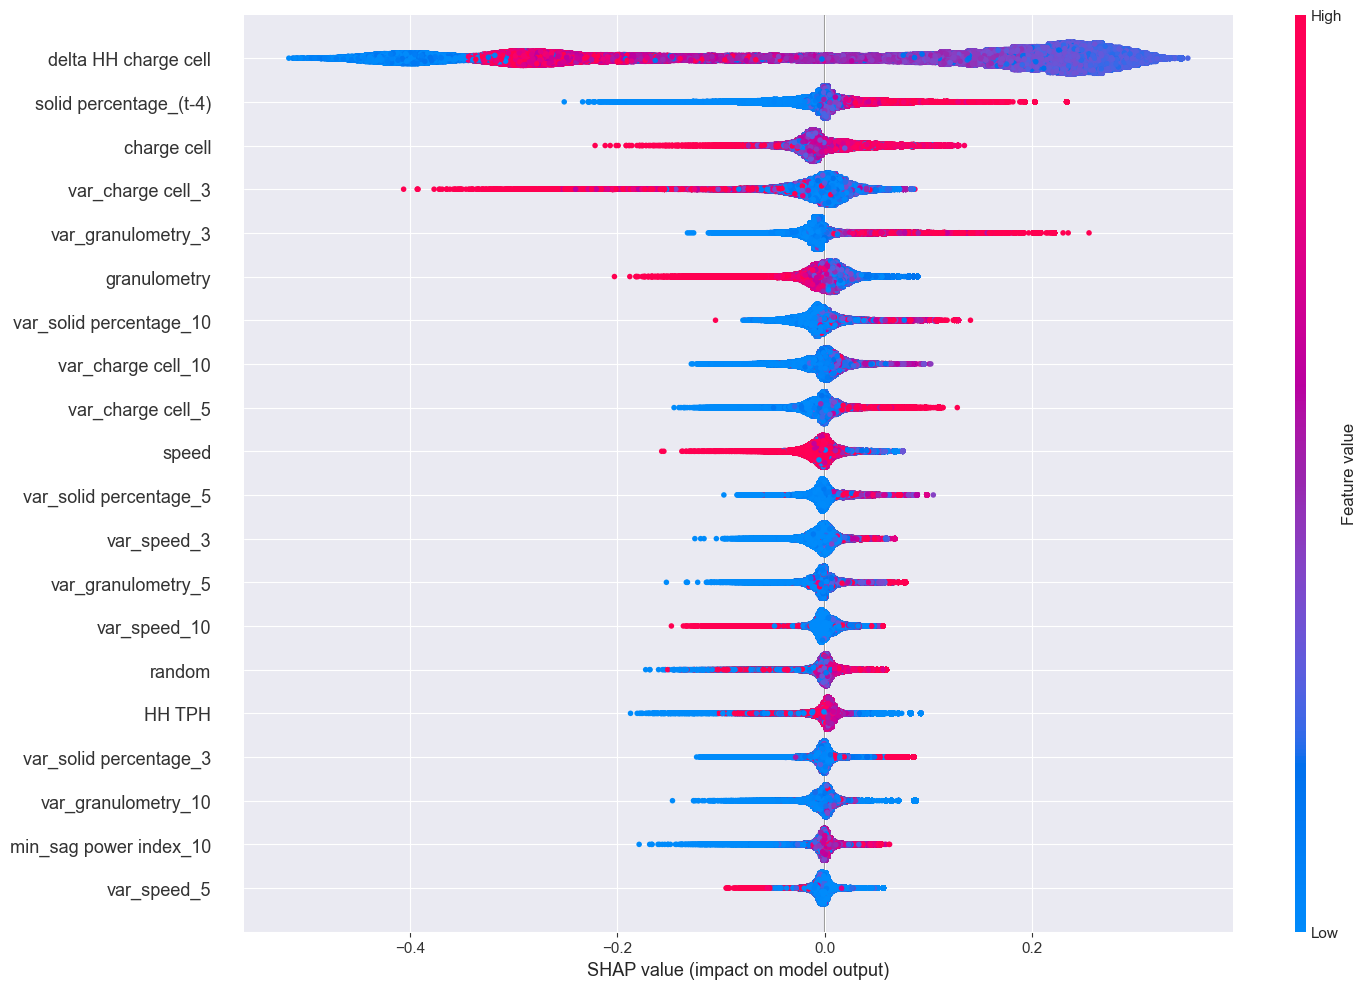

In [114]:
shap.summary_plot(shap_values_Model,Xtrain[tag_select], plot_size=[15,10])

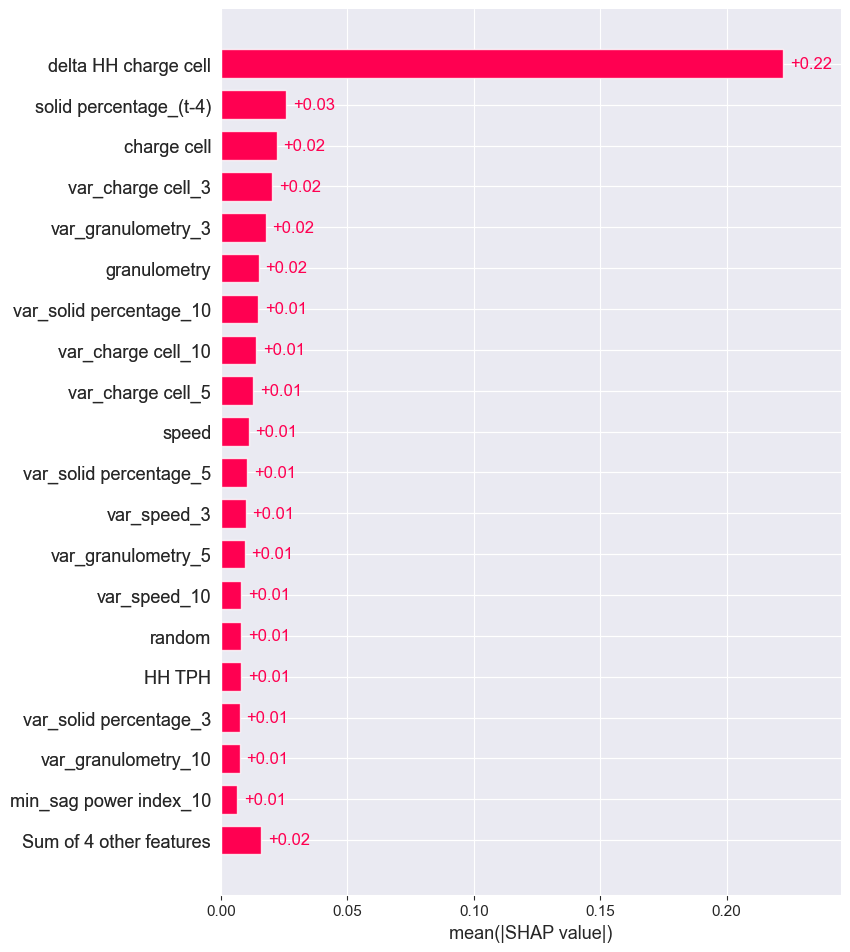

<Figure size 1200x1200 with 0 Axes>

In [115]:
shap.plots.bar(explainerModel_X, max_display=20,)
plt.figure(figsize=(12, 12))
plt.show()